In [1]:
%run ~/.python/init.ipynb

In [2]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [14]:
root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic-regression_small')
train_path = root / 'train'
test_path = root / 'test'

In [15]:
class CARLADataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = sorted([p.parts[-1] for p in self.root.glob("video*.npy")])
        self.labels = sorted([p.parts[-1] for p in self.root.glob("coords*.npy")])

    def __getitem__(self, idx):
        # load images and masks         
        img = np.load(self.root / self.imgs[idx])
        target = np.load(self.root / self.labels[idx])

        # use x,y only
        target = target[[0,1]]
            
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

In [18]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        CARLADataset(train_path, data_transforms['train']),
        batch_size=4,
        shuffle=True,
        num_workers=2),
    'test': torch.utils.data.DataLoader(
        CARLADataset(test_path, data_transforms['test']),
        batch_size=4,
        shuffle=True,
        num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
dataset_sizes

{'train': 1000, 'test': 1000}

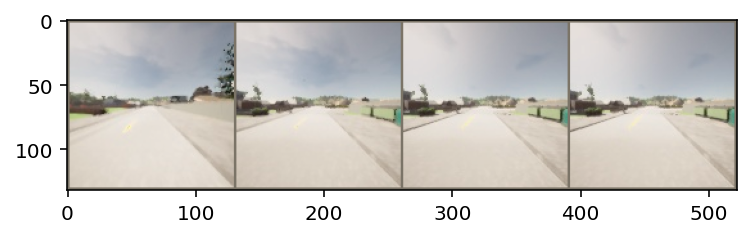

In [20]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [38]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) # added dimension for classification

model_conv = model_conv.to(device)

# regressor loss
regressor_criterion = nn.MSELoss()

# classifier loss
classifier_criterion = nn.BCELoss()
m = nn.Sigmoid()

# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [39]:
inputs, labels = next(iter(dataloaders['train']))
inputs = inputs.to(device)
labels = labels.to(device).float()
outputs = model_conv(inputs)

In [43]:
labels[:, :2]

tensor([[ 93.5441,  61.5139],
        [ 92.3823,  81.5301],
        [ 92.3823,  81.5301],
        [ 92.2900, 157.4825]], device='cuda:0')

In [48]:
reg_loss  = regressor_criterion(outputs[:, :2], labels)
reg_loss
clas_loss = classifier_criterion(m(outputs[:, 2]), torch.ones_like(labels[:, 0]))
clas_loss

tensor(11500.3379, device='cuda:0', grad_fn=<MseLossBackward0>)

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4715.2080
test Loss: 4791.0222

Epoch 1/24
----------
train Loss: 433.3524
test Loss: 4101.0367

Epoch 2/24
----------
train Loss: 125.2412
test Loss: 3590.8456

Epoch 3/24
----------
train Loss: 61.4190
test Loss: 3437.2734

Epoch 4/24
----------
train Loss: 44.4909
test Loss: 3349.2880

Epoch 5/24
----------
train Loss: 32.4247
test Loss: 3568.1731

Epoch 6/24
----------
train Loss: 24.7892
test Loss: 3359.2676

Epoch 7/24
----------
train Loss: 14.6580
test Loss: 3364.6557

Epoch 8/24
----------
train Loss: 13.3147
test Loss: 3415.0455

Epoch 9/24
----------
train Loss: 12.7070
test Loss: 3455.9316

Epoch 10/24
----------
train Loss: 12.3382
test Loss: 3385.8577

Epoch 11/24
----------
train Loss: 11.9256
test Loss: 3373.2617

Epoch 12/24
----------
train Loss: 11.7287
test Loss: 3407.0419

Epoch 13/24
----------
train Loss: 11.4825
test Loss: 3366.2724

Epoch 14/24
----------
train Loss: 11.0538
test Loss: 3377.3517

Epoch 15/24
----------
train Lo

In [18]:
torch.save(model_conv.state_dict(), "./models/model_conv.pt")